# Artificial Intelligence for Business

This Jupyter notebook performs Exploratory Data Analysis (EDA) on one of the six synthetic tabular datasets in the Bank Account Fraud (BAF) suite of datasets. The BAF datasets were published at NeurIPS 2022 and are intended to provide a realistic, complete, and robust test bed to evaluate novel and existing methods in machine learning (ML) and fair ML.

# Project Description

The objective of this notebook is to provide an overview over the dataset and prepare it to be used for training and evaluating ML models.

The BAF suite of datasets comprises a total of 6 different synthetic bank account fraud tabular datasets. The datasets are realistic, based on a present-day real-world dataset for fraud detection, and each dataset has distinct controlled types of bias. Additionally, the datasets have an imbalanced setting with an extremely low prevalence of positive class, contain temporal data and observed distribution shifts, and have privacy-preserving features to protect the identity of potential applicants.

In this notebook, we will be exploring one of the datasets in the BAF suite, the Base.csv dataset.

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from tabulate import tabulate

from sklearn.utils import shuffle
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Data Understanding and Exploration

### Loading and describing the dataset
We start by loading the dataset into a Pandas DataFrame and displaying its first few rows using the head() function. We then display some basic statistics of the dataset using the describe() function.

In [2]:
try:
    # Read in the data
    df = pd.read_csv('../dataset/Base.csv', header=0)
except FileNotFoundError:
    print("Error: File not found.")
except pd.errors.EmptyDataError:
    print("Error: Empty DataFrame.")
except pd.errors.ParserError:
    print("Error: Parsing error occurred.")
except Exception as e:
    print(f"An error occurred: {str(e)}")

df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7


In [ ]:
df.describe()

### Boxplot
We then use the Seaborn library to create boxplots of the numerical columns in the dataset. Boxplots are used to visualize the distribution and outliers of each numerical column.

In [ ]:
# get the list of numerical columns
num_cols = df.select_dtypes(include=['float', 'int']).columns.tolist()

# create a grid of subplots using seaborn
n_cols = 3  # number of columns in the grid
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # number of rows in the grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5*n_rows))

# loop through the columns and create a boxplot for each one
for i, col in enumerate(num_cols):
    row_idx = i // n_cols  # row index for this subplot
    col_idx = i % n_cols  # column index for this subplot
    ax = sns.boxplot(data=df[col], ax=axes[row_idx, col_idx])
    ax.set_title(col)

During the analysis of the boxplots, we have identified a column that contains only a single value, with an equal value for all data inputs. Since this column does not provide any meaningful variation or information, it is recommended to remove it from the dataset before proceeding with further analysis.

In [3]:
column_to_remove = 'device_fraud_count'

# drop the column from the dataframe
df = df.drop(column_to_remove, axis=1)

### Histograms
We can also create histograms of the numerical columns to see the distribution of each feature. This can help us identify any features that may need to be transformed to achieve a normal distribution.

In [ ]:
df.hist(bins=20, figsize=(25, 20))
plt.show()

We can see some columns follow a normal distribution. Those columns are zip_count_4w, velocity_6h, velocity_24h, date_of_birth_distinct_emails_4w, credit_risk_score.

### Count Plot
Finally, we can create a count plot to visualize the distribution of the target variable (fraud). This can help us identify the class imbalance in the dataset.

In [ ]:
# Create a count plot of the target variable
sns.countplot(x='fraud_bool', data=df)
plt.title('Target Variable Distribution')
plt.show()

### Division of Variables
The variables have been grouped as follows:
- Target variable: Variable of interest in the project
- Continuous variables: These variables represent quantitative measurements
- Categorical variables: These variables represent a finite set of possible values
- Binary variables: These variables have two distinct values, normally representing a yes/no condition.

In [4]:
continuous_cols = ['income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'proposed_credit_limit', 'session_length_in_minutes', 'device_distinct_emails_8w']
binary_cols = ['fraud_bool', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session']
discrete_cols = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'month']
normal_distribution_cols = ['zip_count_4w', 'velocity_6h', 'velocity_24h', 'date_of_birth_distinct_emails_4w', 'credit_risk_score']
target_col = 'fraud_bool'

# Exploratory Data Analysis (EDA)

### Analyzing Outliers
Outliers can take many different forms in a dataset. In some cases, outliers may be extreme values that fall far outside the expected range of the data, while in other cases, outliers may appear as discontinuities or gaps in the data.

In this particular dataset, it has been observed that there are some columns - customer_age, days_since_request, intended_balcon_amount, and proposed_credit_limit - that contain discontinuous points, based on the boxplots. These points may represent missing data or errors in data collection, or they may be indicative of some other pattern in the data.

In [ ]:
columns_to_analyze = ['customer_age', 'days_since_request', 'intended_balcon_amount', 'proposed_credit_limit', 'device_distinct_emails_8w']

# create a grid of subplots using seaborn
n_cols = 2  # number of columns in the grid
n_rows = (len(columns_to_analyze) + n_cols - 1) // n_cols  # number of rows in the grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 5*n_rows))

# loop through the columns and create a boxplot for each one
for i, col in enumerate(columns_to_analyze):
    row_idx = i // n_cols  # row index for this subplot
    col_idx = i % n_cols  # column index for this subplot
    ax = sns.scatterplot(x=col, y=target_col, data=df, ax=axes[row_idx, col_idx])
    ax.set_title(col)

Upon examining the selected columns, we did not find significant differences in the values between the fraud and non-fraud categories. This suggests that outliers in these variables are not particularly informative or indicative of fraud. Instead, they may be a result of random variations or noise in the data.

Considering these findings, it may not be necessary to remove outliers from these variables to improve the accuracy of your analysis or model.

### Correlation Matrix
We can calculate the correlation matrix between the numerical features in the dataset to see how they are related to each other. This can give us some insight into which features are most important for predicting fraud.

In [ ]:
# Calculate the correlation matrix
corr_matrix = df[continuous_cols].corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(25, 30))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 10})
plt.title('Correlation Matrix')
plt.show()

Takeaways:
- income has a positive correlation with customer_age and credit_risk_score, indicating that higher income tends to be associated with older customers and higher credit risk scores.
- prev_address_months_count and current_address_months_count have a negative correlation, indication that customers with longer previous addresses tend to have shorter current addresses.
- customer_age has a negative correlation with date_of_birth_distinct_emails_4w, indicating that a higher number of distinct emails for applicants with the same date of birth in the last 4 weeks may be associated with younger customers.
- the variables related to velocity (velocity_6h, velocity_24h, velocity_4w) have positive correlations with each other, indicating that higher velocity in one timeframe is generally associated with higher velocity in other timeframes.
- credit_risk_score has a strong positive correlation with proposed_credit_limit, indicating that higher credit risk scores are more likely to have higher proposed credit limits.

### Correlation between continuous variables and our target (binary) variable

#### Visualizing the distributions between fraud and non-fraud categories

In [ ]:
# Set the number of columns and rows in the grid
num_cols = 3
num_rows = (len(continuous_cols) + num_cols - 1) // num_cols

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array
axes = axes.flatten()

# Create box plots for each continuous variable
for i, col in enumerate(continuous_cols):
    ax = axes[i]
    sns.boxplot(x=target_col, y=col, data=df, ax=ax)
    ax.set_title(f"{col} by {target_col}")

# Remove any empty subplots
if len(continuous_cols) < len(axes):
    for j in range(len(continuous_cols), len(axes)):
        fig.delaxes(axes[j])

# Adjust the layout
fig.tight_layout()

# Show the plot
plt.show()

We can see there is slighty different distributions on the income, date_of_birth_distinct_emails_4w, proposed_credit_limit columns between fraud and non-fraud categories. We can also see that the distributions of the other variables are similar between the two categories. This suggests that these variables may not be particularly informative for predicting fraud, however the those three variables may be useful in predicting fraud.

#### T-test

The t-test is commonly used to compare the means of two groups or conditions. It is suitable for situations where we have a continuous outcome variable and a binary variable, our target variable.

The t-test assumes the continuous outcome variable is normally distributed and that the variance of the two groups is equal. Therefore, we perform Levene's test to check the equality of variances between the groups.

In [ ]:
print('Levene\'s Test')

# Split the data into two groups based on the binary variable
for col in normal_distribution_cols:
    group_1 = df[df[target_col] == 0][col]
    group_2 = df[df[target_col] == 1][col]

    statistic, p_value = stats.levene(group_1, group_2)

    # Print the test results
    print(f"Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

If the p-value from Levene's test is below the chosen significance level (e.g., 0.05), it indicates a statistically significant difference in variances between the groups. This would violate the assumption of equal variances required for the t-test, and thus we would need to explore alternative tests.

Looking at the Levene's test results, we analize that the variance between the two groups is statistically significant.

We will use the Mann-Whitney U test, which does not assume equal variances.

#### Mann-Whitney U Test

The Mann-Whitney U test is a non-parametric test that does not rely on the assumption of equal variances. It compares the distributions of two independent groups based on the ranks of the observations.

This test is appropriate when the data do not meet the assumptions required for the T-test, such as when the data are non-normally distributed or the variances are unequal.

In [ ]:
effect_sizes = []
results_mannwhitneyu = []

for col in continuous_cols:
    group_1 = df[df[target_col] == 0][col]
    group_2 = df[df[target_col] == 1][col]

    stat, p_value_mannwhitneyu = stats.mannwhitneyu(group_1, group_2)
    results_mannwhitneyu.append((col, stat, p_value_mannwhitneyu))

    # Calculate Cohen's U3
    u3 = stat / (len(group_1) * len(group_2))
    effect_sizes.append((col, u3, p_value_mannwhitneyu))

df_mannwhitneyu = pd.DataFrame(results_mannwhitneyu, columns=['Variable', 'Mann-Whitney U', 'P-value (Mann-Whitney U)'])
effect_sizes_df = pd.DataFrame(effect_sizes, columns=['Variable', "Cohen's U3", 'P-value (Mann-Whitney U)'])

In [ ]:
df_mannwhitneyu.plot(x='Variable', y='P-value (Mann-Whitney U)', kind='bar')
plt.title('Mann-Whitney U')
plt.ylabel('P-value')
plt.show()

In [ ]:
print(df_mannwhitneyu)

The resulting p-value from the test represents the probability of observing a U statistic as extreme as the one calculated, assuming that the null hypothesis is true (i.e., the distributions of the two groups are identical). A small p-value indicates strong evidence against the null hypothesis and suggests that there is a significant difference between the two groups (fraud and non-fraud).

We will now visualize the magnitude of the differences between the fraud and non-fraud categories for each variable.

In [ ]:
variable_names = effect_sizes_df['Variable']
cohens_u3 = effect_sizes_df["Cohen's U3"]
p_values = effect_sizes_df['P-value (Mann-Whitney U)']

bar_width = 0.35

x_indices = np.arange(len(variable_names))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x_indices - bar_width, p_values, bar_width, label='P-value')
bar2 = ax.bar(x_indices + bar_width, cohens_u3, bar_width, label="Cohen's U3")

ax.set_xticks(x_indices + bar_width)
ax.set_xticklabels(variable_names, rotation=90)

ax.set_ylabel('Value')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(effect_sizes_df)

A Cohen's U3 effect size of 0.6 is considered relatively large, it indicates a substatial difference between the two groups, value we can see on the date_of_birth_distinct_emails_4w. The p-values are so close to 0.0 that we they do not appear visible in the plot, however this means the confidence on the difference between the two groups is very high.

#### Point-Biserial Correlation

In this section, we perform a point-biserial correlation analysis to examine the relationship between the target variable and the continuous variables in the dataset.

First, we calculate the point-biserial correlation coefficients and p-values for each continuous variable. The correlation coefficient measures the strength and direction of the relationship, while the p-value indicates the statistical significance of the correlation.

In [ ]:
# Assuming your DataFrame is named 'df' and the target variable column is 'target_col'
binary_var = df[target_col]

coefficients = []
p_values = []

for var in continuous_cols:
    correlation, p_value = stats.pointbiserialr(binary_var, df[var])
    coefficients.append(correlation)
    p_values.append(p_value)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot coefficients
ax1.bar(np.arange(len(continuous_cols)), coefficients, tick_label=continuous_cols)
ax1.set_xlabel('Continuous Variables')
ax1.set_ylabel('Point-Biserial Correlation Coefficient')
ax1.set_title('Point-Biserial Correlation Coefficients')
ax1.tick_params(axis='x', rotation=60)  # Rotate x-axis labels by 60 degrees

# Plot p-values
ax2.bar(np.arange(len(continuous_cols)), p_values, tick_label=continuous_cols)
ax2.set_xlabel('Continuous Variables')
ax2.set_ylabel('p-value')
ax2.set_title('P-values')
ax2.tick_params(axis='x', rotation=60)  # Rotate x-axis labels by 60 degrees

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

The bar plots display the correlation coefficients and p-values side by side. The x-axis represents the continuous variables, while the y-axis represents the correlation coefficient or p-value. The coefficients indicate the degree of association between the continuous variables and the target variable, while the p-values help assess the significance of these associations.

From the analysis, we can gain insights into which continuous variables have a strong or weak relationship with the target variable. Higher coefficients indicate a stronger association, while lower p-values suggest a more significant relationship.

In the point-biserial correlation test, the variable days_since_request has a p-value above 0.5, which means there is no evidence to support a significant relationship between this variable and the target variable.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Boxplot 1
sns.boxplot(x=target_col, y='days_since_request', data=df[df[target_col] == 0][[target_col, 'days_since_request']], ax=axes[0])
axes[0].set_title('Boxplot - Days since request, NOT Fraud')
axes[0].set_xlabel(target_col)
axes[0].set_ylabel('days_since_request')

# Boxplot 2
sns.boxplot(x=target_col, y='days_since_request', data=df[df[target_col] == 1][[target_col, 'days_since_request']], ax=axes[1])
axes[1].set_title('Boxplot - Days since request, Fraud')
axes[1].set_xlabel(target_col)
axes[1].set_ylabel('days_since_request')

plt.tight_layout()
plt.show()

In the case of the 'days_since_request' variable, the point-biserial correlation analysis and boxplot visualization did not reveal any clear difference between fraud and non-fraud cases. The p-value for this variable was above 0.5, indicating no significant association with the target variable.

### Correlation between categorical variables and our target (binary) variable

#### Chi-square test
We want to perceive the relation between the categorical features in the dataset to see how they are related to the target variable. This can give us some insight into which features are most important for predicting fraud.

(Note: chosen significance level (alpha) = 0.05)

In [ ]:
col_names = ["Variable", "Chi-square Statistic", "Degrees of freedom", "P-value"]

data = []

for col in discrete_cols + binary_cols:
    if(col == target_col): continue

    contingency_table = pd.crosstab(df[target_col], df[col])

    chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

    data.append([col, chi2_stat, dof, p_val])

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

In this table, we have 4 columns:
- **Variable** <br>
Name of the variable being analised.

- **Chi-square Statistic** <br>
Measures the overall discrepancy between the observed frequencies and the expected frequencies under the assumption of independence. A larger chi-square statistic suggests a greater difference between the observed and expected frequencies.

- **Degree of freedom** <br>
Represent the number of categories in the variables minus 1. In the context of a chi-square test, it determines the critical values or the distribution of the chi-square statistic. The degrees of freedom help in assessing the statistical significance of the chi-square test.

- **P-value** <br>
Indicates the statistical significance of the association, if the p-value is below a chosen significance level (alpha < 0.05), it suggests a significant association.

Through analysis of the results, we can conclude that, for all the variables analysed, in none of them the p-value is higher or equal to the chosen significance level (alpha = 0.05), only lower. What we can perceive from the fact that the p-value is zero (or near zero) is that the observed results are highly unlikely to be due to random chance, and there is a significant relationship or effect present in the data. As a result, we can only take conclusions based on the chi-square Statistic and the degrees of freedom of each variable. Normally, the higher the degree of freedom the higher the chi-square statistic tends to be. By observing the table, we can understand that some variables have stronger relation with the target variable, such as "device_os", "housing_status", "email_is_free", "phone_home_valid", "has_other_cards" and "keep_alive_session".

## Feature Engineering and Selection

### Data Encoding
In order to encode some of our variables, we looked up some of the most used encoding methods. We ended up choosing Ordinal Encoding for High-Cardinality Variables because we have categorical variables with a high number of unique values (high-cardinality). Being that using One-Hot Encoding might lead to a large number of resulting columns and given that we want to reduce the number of columns, One-Hot Encoding turns out not being the best choice. So we decided to use Ordinal Encoding, which assigns unique integers to each category.

In [5]:
dataset = df.copy()

columns_to_encode = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']

encoder = OrdinalEncoder()

dataset[columns_to_encode] = encoder.fit_transform(dataset[columns_to_encode])

## Data Normalization

TODO: Explain why we need to normalize the data

In [6]:
normalized_dataset = dataset.copy()

# Select the columns to normalize (excluding the target variable)
columns_to_normalize = dataset.columns.drop(target_col)

scaler = StandardScaler()

# Fit the scaler on the selected columns
scaler.fit(normalized_dataset[columns_to_normalize])

# Transform the selected columns using the scaler
normalized_dataset[columns_to_normalize] = scaler.transform(normalized_dataset[columns_to_normalize])

dataset = normalized_dataset.copy()

Our dataset is 1 Million lines long, so we decided to use only 10% of the dataset to work with, in order to reduce the time it takes to run the models.

In [7]:
fraud_class = dataset[dataset[target_col] == 1]
not_fraud_class = dataset[dataset[target_col] == 0]

fraud_samples = fraud_class.sample(frac=0.1, random_state=1)
not_fraud_samples = not_fraud_class.sample(frac=0.1, random_state=1)

dataset = pd.concat([fraud_samples, not_fraud_samples])

### Selecting relevant features
In this step we select the features that have the most impact on our target variable ("fraud_bool"). 

After usage of various statistical techniques and respective analysis, as shown in the steps above, the features that we perceived as being of more relevance were the following: 
- "income"
- "date_of_birth_distinct_emails_4w"
- "credit_risk_score"
- "device_os"
- "housing_status"
- "email_is_free"
- "phone_home_valid"
- "has_other_cards"
- "keep_alive_session"
- "velocity_6h"

In [8]:
relevant_features = ["fraud_bool", "income", "date_of_birth_distinct_emails_4w", "credit_risk_score", "device_os", 
                     "housing_status", "email_is_free", "phone_home_valid", "has_other_cards", "keep_alive_session", 
                     "velocity_6h"]

### Imbalanced Dataset
#### Undersampling vs Oversampling vs SMOTE
Dealing with imbalanced datasets is an important aspect of machine learning. In this section, we will explore some techniques for dealing with imbalanced datasets.



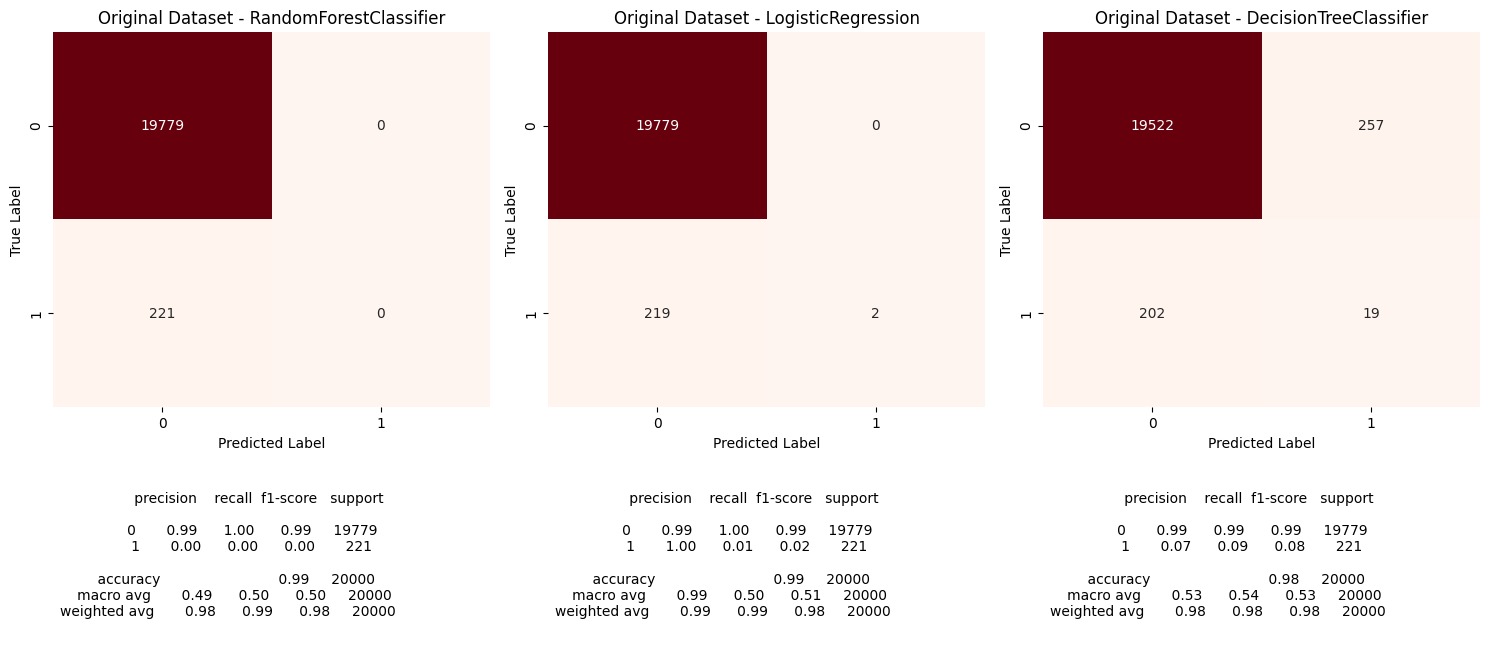

In [9]:
def plot_confusion_matrix(axes, report, cm, info):
    ax = axes
    ax.text(0.4, -.6, report, transform=ax.transAxes, fontsize=10, ha='center')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'{dataset_info[info]} - {clf.__class__.__name__}')

dataset_info = ["Original Dataset", "Under-sampled Dataset", "Over-sampled Dataset", "SMOTE Dataset"]
algorithm = [RandomForestClassifier(random_state=1), LogisticRegression(random_state=1, max_iter= 1000), DecisionTreeClassifier(random_state=1)]

training_data = dataset.copy()

# Separate the features and the target variable
X = training_data.drop(target_col, axis=1)
y = training_data[target_col]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)


# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=1)

# Train various classifiers
num_cols = 3
num_rows = (len(algorithm) + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

for i, clf in enumerate(algorithm):
    clf.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    report = classification_report(y_test, y_pred, zero_division=0)

    # Plot the confusion matrix
    plot_confusion_matrix(axes[i], report, cm, 0)

plt.tight_layout()
plt.show()

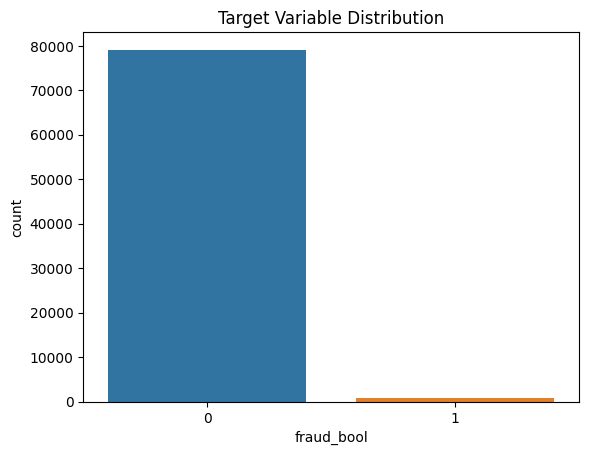

In [10]:
sns.countplot(x=y_train)
plt.title('Target Variable Distribution')
plt.show()

The original dataset without any techniques applied to deal with the imbalanced dataset results in a model that is biased towards predicting non-fraud cases. As we can see from the confusion matrixes, the models are not able to predict fraud cases, which is the main objective of this project.

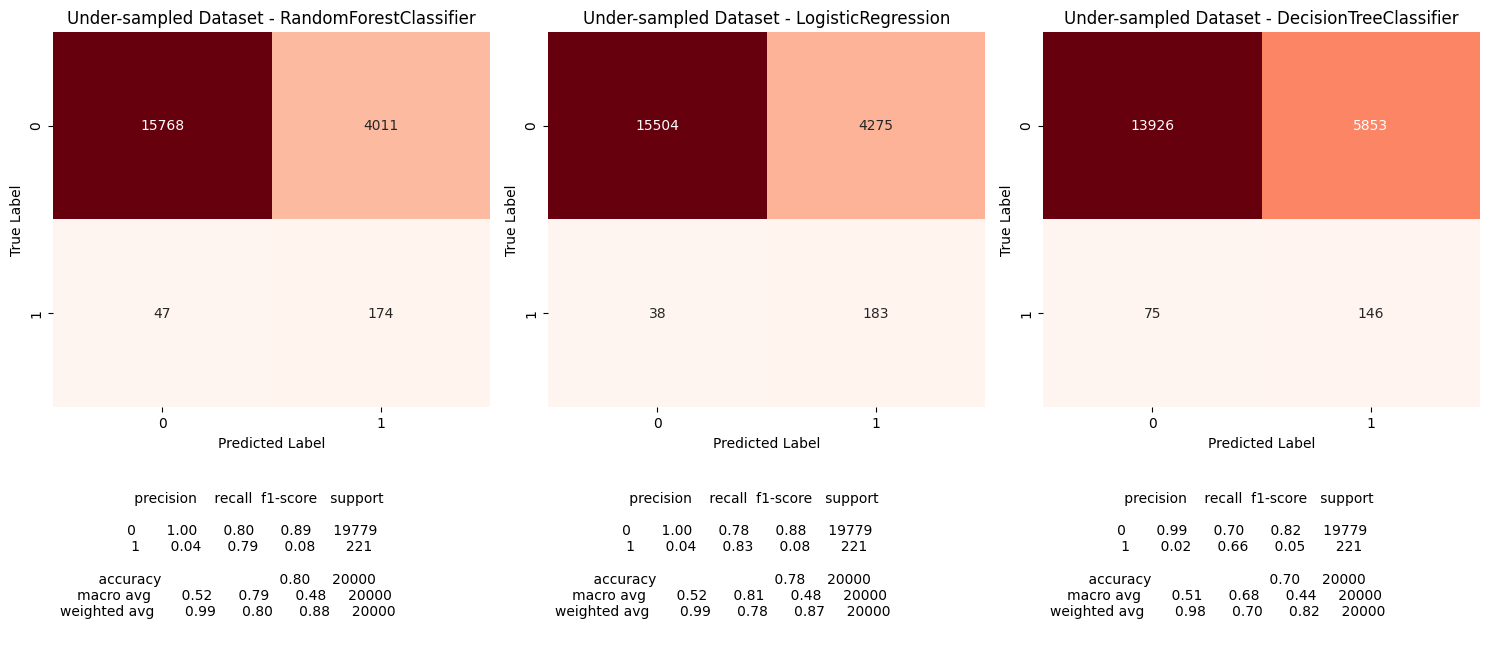

In [11]:

# Apply Random Under-sampling to balance the data
rus = RandomUnderSampler(random_state=1)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X_train, y_train)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))

# Evaluate the model on the test set
predicted_us = []
for i, clf in enumerate(algorithm):
    clf.fit(X_resampled_rus, y_resampled_rus)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)
    predicted_us.append(y_pred)


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    report = classification_report(y_test, y_pred, zero_division=0)

    # Plot the confusion matrix
    plot_confusion_matrix(axes[i], report, cm, 1)



plt.tight_layout()
plt.show()

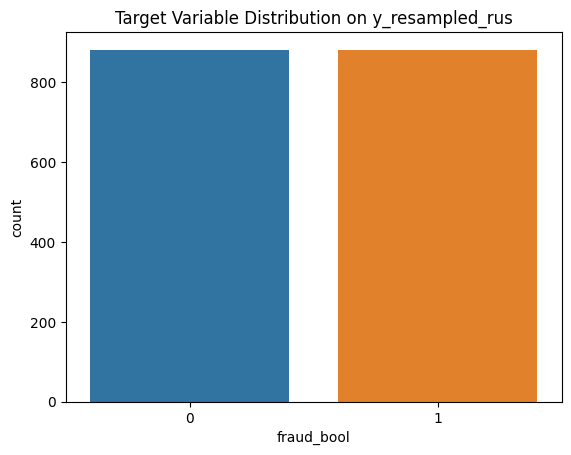

In [12]:
sns.countplot(x=y_resampled_rus)
plt.title('Target Variable Distribution on y_resampled_rus')
plt.show()

Aplying a undersampling technique, we can see that the target variable is now balanced. Analyzing the confusion matrixes of the different classifiers, we infer that the model is now predicting some fraud cases correctly, but it is also predicting a lot of non-fraud cases as fraud. This is not ideal, because we want to predict fraud cases, but we also want to minimize the number of non-fraud cases that are predicted as fraud.

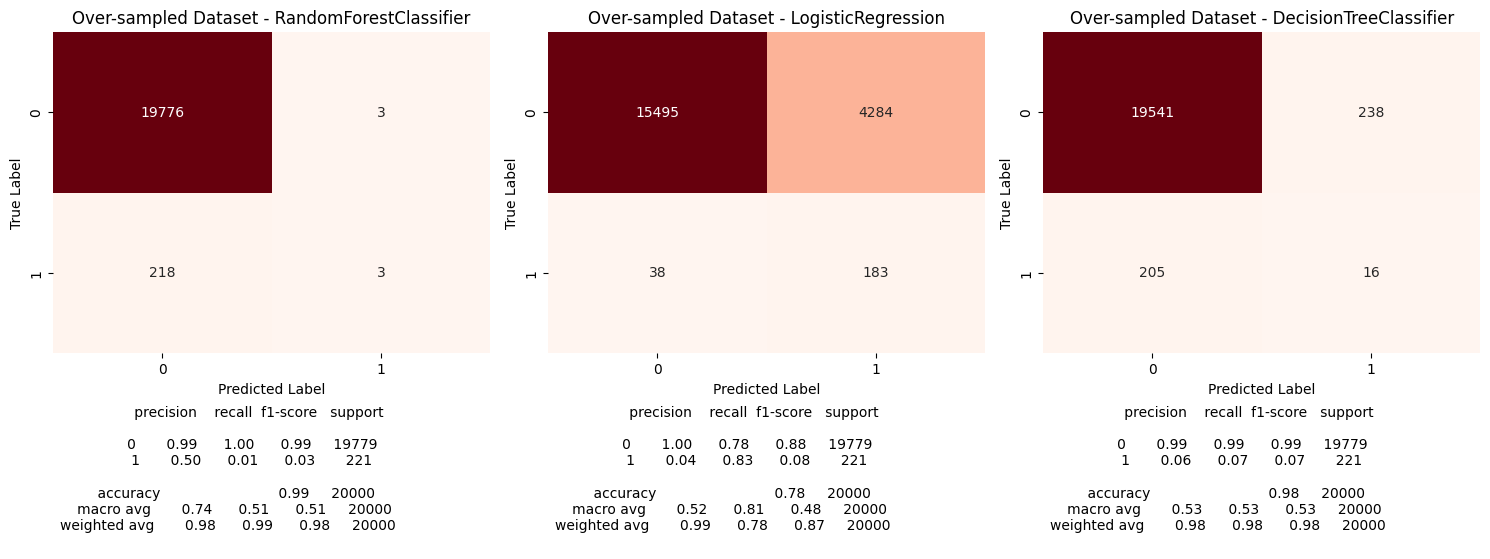

In [13]:
# Apply Random Over-sampling to balance the data
ros = RandomOverSampler(random_state=1)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X_train, y_train)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

# Evaluate the model on the test set
predicted_os = []
for i, clf in enumerate(algorithm):
    clf.fit(X_resampled_ros, y_resampled_ros)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)
    predicted_os.append(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    report = classification_report(y_test, y_pred, zero_division=0)

    # Plot the confusion matrix
    plot_confusion_matrix(axes[i], report, cm, 2)

plt.tight_layout()
plt.show()

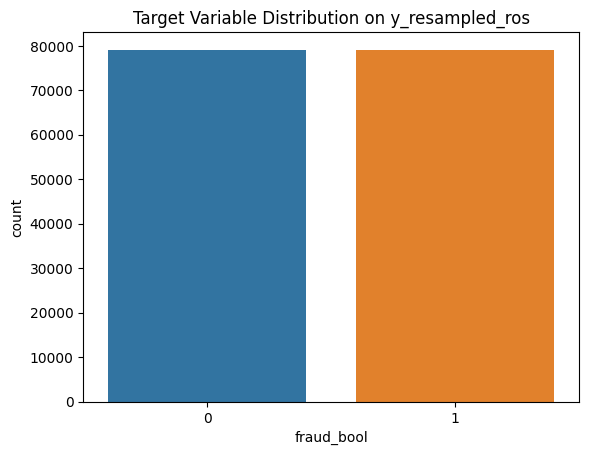

In [14]:
sns.countplot(x=y_resampled_ros)
plt.title('Target Variable Distribution on y_resampled_ros')
plt.show()

Aplying a oversampling technique, randomly duplicates instances of the minority class until the dataset is balanced as we can tell by the target variable distribution.
By observing the confusion matrixes, the results are very different from the classifiers, so it is difficult to draw conclusions.

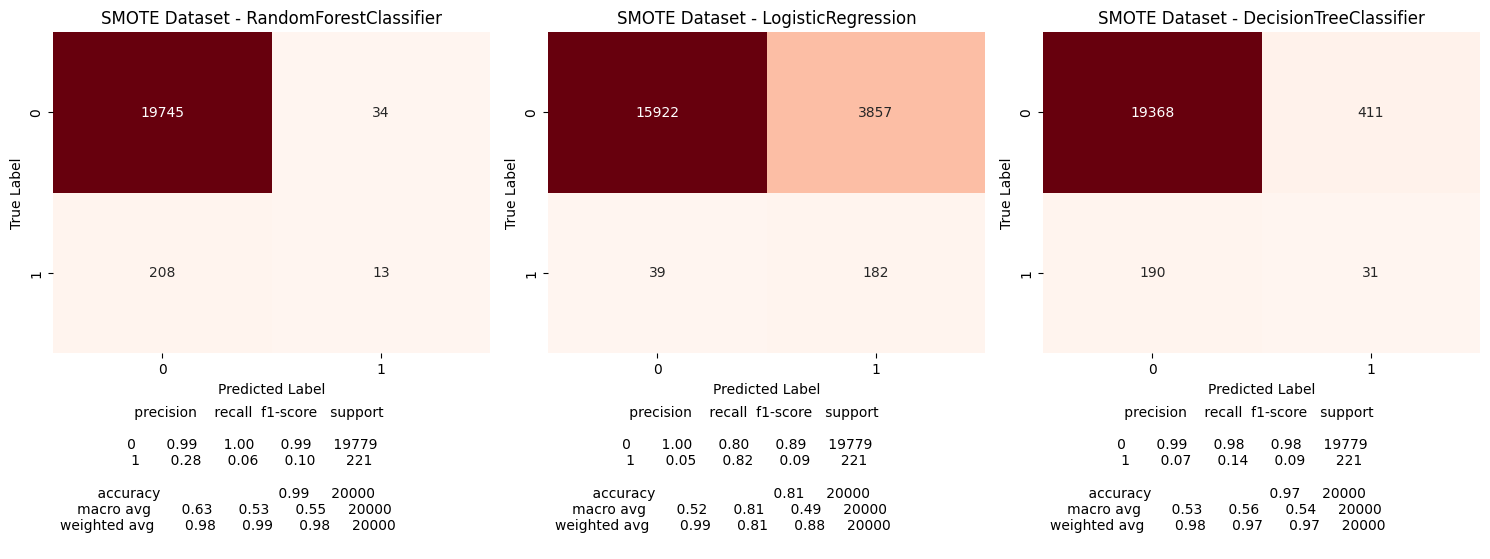

In [15]:
# Apply SMOTE to balance the data
smote = SMOTE(random_state=1)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7))

predicted_smote = []
# Evaluate the model on the test set

for i, clf in enumerate(algorithm):
    clf.fit(X_resampled_smote, y_resampled_smote)

    # Evaluate the model on the test set
    y_pred = clf.predict(X_test)
    predicted_smote.append(y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    report = classification_report(y_test, y_pred, zero_division=0)

    # Plot the confusion matrix
    plot_confusion_matrix(axes[i], report, cm, 3)

plt.tight_layout()
plt.show()

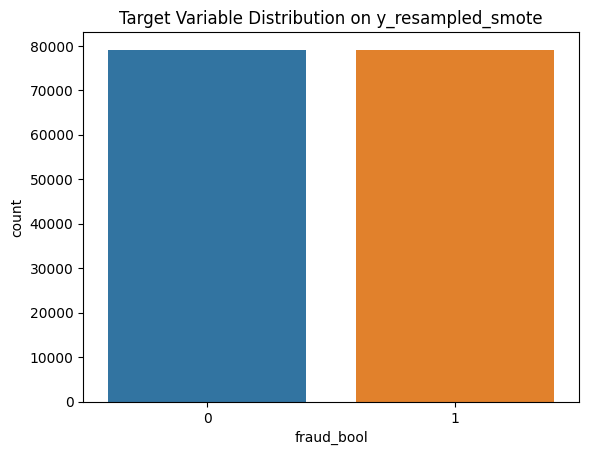

In [16]:
sns.countplot(x=y_resampled_smote)
plt.title('Target Variable Distribution on y_resampled_smote')
plt.show()


Concerning the Smote technique, although the improvements were relatively small we noticed a slight improvement regarding the original dataset.
The results are similar to the previous technique, as the smote is a oversampling technique which creates synthetic instances of the minority class.



### Roc Curves

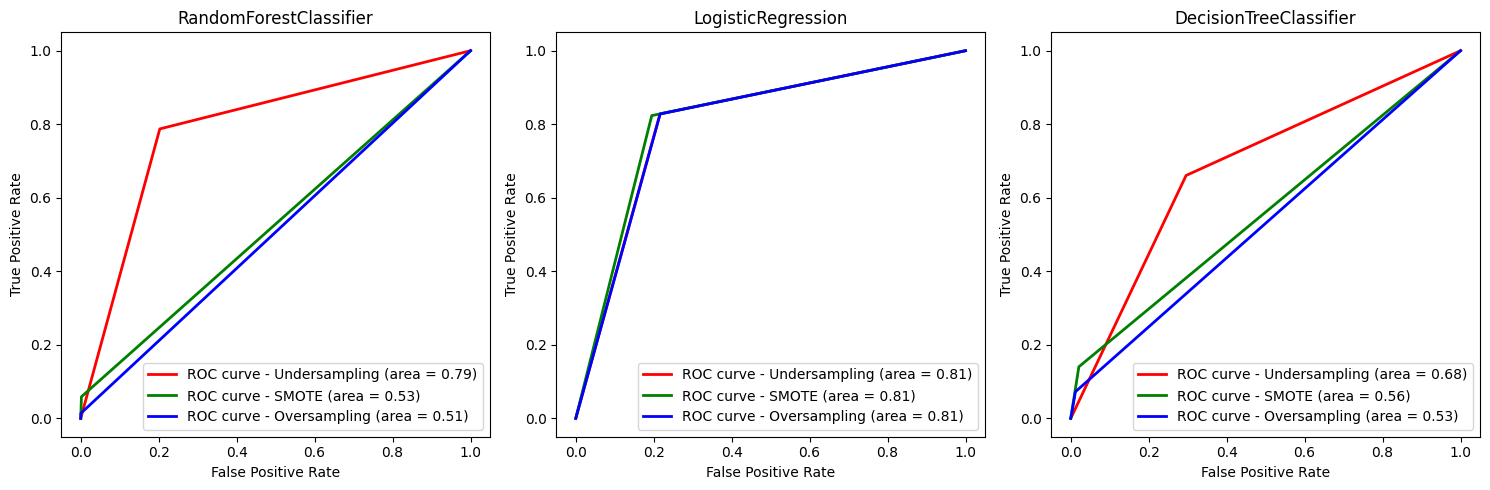

In [17]:
# Compute the false positive rate (FPR), true positive rate (TPR), and threshold
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


for i in range(len(algorithm)):
    # Undersampling
    fpr_undersampling, tpr_undersampling, thresholds = roc_curve(y_test, predicted_us[i])
    auc_undersampling = auc(fpr_undersampling, tpr_undersampling)
    axes[i].set_title(f'{algorithm[i].__class__.__name__}')
    axes[i].plot(fpr_undersampling, tpr_undersampling, color='red', lw=2, label='ROC curve - Undersampling (area = %0.2f)' % auc_undersampling)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')


    # SMOTE
    fpr_smote, tpr_smote, thresholds = roc_curve(y_test, predicted_smote[i])
    auc_smote = auc(fpr_smote, tpr_smote)
    axes[i].plot(fpr_smote, tpr_smote, color='green', lw=2, label='ROC curve - SMOTE (area = %0.2f)' % auc_smote)



    # Oversampling
    fpr_oversampling, tpr_oversampling, thresholds = roc_curve(y_test, predicted_os[i])
    auc_oversampling = auc(fpr_oversampling, tpr_oversampling)
    axes[i].plot(fpr_oversampling, tpr_oversampling, color='blue', lw=2, label='ROC curve - Oversampling (area = %0.2f)' % auc_oversampling)


    axes[i].legend()


plt.tight_layout()
plt.show()

The ROC curve is useful for visualizing the performance of a binary classifier. It plots the true positive rate (TPR) against the false positive rate (FPR) for different threshold values. The area under the curve (AUC) is a great measure to compare different models.
As we can see from the ROC curves, the technique that appears to deal better with this specific imbalanced dataset is the undersampling technique, as it has the highest AUC score throughout all the classifiers.

## Main Takeaways from Analysis

TODO: Add more details about the main takeaways from analysis and preprocessing phase

Overall, the results confirm that the original dataset suffers from severe class imbalance, leading to poor performance in identifying fraudulent cases. While the applied techniques (under-sampling, over-sampling, and SMOTE) show some improvements in identifying fraudulent cases compared to the original dataset, the performance remains limited. We will need to further analyse and experiment to develop a  more effective model for fraud detection in this dataset.

## Datasets preparation for the models

In [18]:
# List of dataframes we will disponibilize throughout the notebook

df_all_features = -1
df_most_correlated_features = -1
df_least_correlated_features = -1

In [19]:
def separate_train_test(dataset, target_col):
    # Separate the features and the target variable
    X = dataset.drop(target_col, axis=1)
    Y = dataset[target_col]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

    # Shuffle the training data
    X_train, Y_train = shuffle(X_train, y_train, random_state=1)

    return X_train, X_test, Y_train, y_test


undersample = RandomUnderSampler(random_state=1)


# all features
df_all_features = dataset.copy()
X_train_all_features, X_test_all_features, Y_train_all_features, Y_test_all_features = separate_train_test(df_all_features, target_col)
df_all_features_train = pd.concat([X_train_all_features, Y_train_all_features], axis=1)
df_all_features_test = pd.concat([X_test_all_features, Y_test_all_features], axis=1)

# all features undersampled
X_train_all_features_under, Y_train_all_features_under = undersample.fit_resample(X_train_all_features, Y_train_all_features)
df_all_features_undersampled_train = pd.concat([X_train_all_features_under, Y_train_all_features_under], axis=1)
df_all_features_undersampled_test = pd.concat([X_test_all_features, Y_test_all_features], axis=1)


# least correlated features
least_correlated = dataset.columns[~dataset.columns.isin(relevant_features[1:])]
df_least_correlated_features = dataset[least_correlated].copy()
X_train_least_correlated, X_test_least_correlated, Y_train_least_correlated, Y_test_least_correlated = separate_train_test(df_least_correlated_features, target_col)
df_least_correlated_features_train = pd.concat([X_train_least_correlated, Y_train_least_correlated], axis=1)
df_least_correlated_features_test = pd.concat([X_test_least_correlated, Y_test_least_correlated], axis=1)

# least correlated features undersampled
X_train_least_correlated_under, Y_train_least_correlated_under = undersample.fit_resample(X_train_least_correlated, Y_train_least_correlated)
df_least_correlated_features_undersampled_train = pd.concat([X_train_least_correlated_under, Y_train_least_correlated_under], axis=1)
df_least_correlated_features_undersampled_test = pd.concat([X_test_least_correlated, Y_test_least_correlated], axis=1)


# most correlated features
df_most_correlated_features = dataset[relevant_features].copy()
X_train_most_correlated, X_test_most_correlated, Y_train_most_correlated, Y_test_most_correlated = separate_train_test(df_most_correlated_features, target_col)
df_most_correlated_features_train = pd.concat([X_train_most_correlated, Y_train_most_correlated], axis=1)
df_most_correlated_features_test = pd.concat([X_test_most_correlated, Y_test_most_correlated], axis=1)

# most correlated features undersampled
X_train_most_correlated_under, Y_train_most_correlated_under = undersample.fit_resample(X_train_most_correlated, Y_train_most_correlated)
df_most_correlated_features_undersampled_train = pd.concat([X_train_most_correlated_under, Y_train_most_correlated_under], axis=1)
df_most_correlated_features_undersampled_test = pd.concat([X_test_most_correlated, Y_test_most_correlated], axis=1)


df_all_features_undersampled = {"train": df_all_features_undersampled_train, "test": df_all_features_undersampled_test}
df_least_correlated_features_undersampled = {"train": df_least_correlated_features_undersampled_train, "test": df_least_correlated_features_undersampled_test}
df_most_correlated_features_undersampled = {"train": df_most_correlated_features_undersampled_train, "test": df_most_correlated_features_undersampled_test}


dataframes = [df_all_features_undersampled, df_least_correlated_features_undersampled, df_most_correlated_features_undersampled]
dataframes_names = ["all_features", "least_correlated_features", "most_correlated_features"]

## Statistical Modeling

### Choosing modeling techniques
The modeling techniques chosen are: 
- Naive Bayes
- Decision Tree
- k-Nearest Neighbours (KNN)
- Logistic Regression
- Support Vectors (SVM)
- Random Forest

### Applying models and evaluating performance
In this section, we apply the models chosen and evaluate their performance with appropriate metrics.

The metrics chosen are the following:
- Accuracy

#### Naive Bayes
Naive Bayes is a classification algorithm based on Bayes' theorem. It assumes that features are independent and calculates the probability of an instance belonging to a class. It's computationally efficient, works well with high-dimensional data, and performs best when the independence assumption holds.

In [20]:
# Define the Naive Bayes classifier
nb = GaussianNB()

# Create a list to store the results
results = []

# Iterate over each dataset
for data in dataframes:
    # Separate the features and target variable
    X = data.drop(target_col, axis=1)
    Y = data[target_col]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

    # Fit the Naive Bayes classifier
    nb.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = nb.predict(X_test)

    # Calculate and store the classification report and confusion matrix
    report = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Append the results to the list
    results.append((report, cm))

# Plot the results

num_cols = 3
num_rows = (len(results) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))



plt.subplots_adjust(hspace=1.5, wspace=0.2)

for i, (report, cm) in enumerate(results):

    ax = axes[i // num_cols, i % num_cols]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=9)
    ax.set_ylabel('True Label', fontsize=9)
    ax.set_title(dataframes_names[i], fontsize=10)

    # Create a text box below the plot to display the classification report
    text_box = ax.text(0.5, -1, str(report), fontsize=7, ha='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))



fig.suptitle('Naive Bayes', fontsize=16, y=0.93)


plt.show()

AttributeError: 'dict' object has no attribute 'drop'

#### Decision Tree
Decision Trees are classification algorithms that create a tree-like model of decisions. Each internal node represents a feature, and each leaf node represents a class label. They split the data based on feature values to create homogeneous subsets. When making predictions, a new instance traverses the tree to a leaf node, and the corresponding class label is assigned. Decision Trees are interpretable and handle categorical and numerical data, capturing complex decision boundaries.

In [ ]:
# Define the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=1)

# Create a list to store the results
results = []

# Iterate over each dataset
for data in dataframes:
    # Separate the features and target variable
    X = data.drop(target_col, axis=1)
    Y = data[target_col]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

    # Fit the Decision Tree classifier
    dt.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = dt.predict(X_test)

    # Calculate and store the classification report and confusion matrix
    report = classification_report(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    # Append the results to the list
    results.append((report, cm))

# Plot the results

num_cols = 3
num_rows = (len(results) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 14))

plt.subplots_adjust(hspace=1.5, wspace=0.2)

for i, (report, cm) in enumerate(results):
    ax = axes[i // num_cols, i % num_cols]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=9)
    ax.set_ylabel('True Label', fontsize=9)
    ax.set_title(dataframes_names[i], fontsize=10)

    # Create a text box below the plot to display the classification report
    text_box = ax.text(0.5, -1, str(report), fontsize=7, ha='center', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

fig.suptitle('Decision Tree', fontsize=16, y=0.93)

plt.show()






#### k-Nearest Neighbours (KNN) 
k-Nearest Neighbors (KNN) is a classification algorithm that predicts the class of an instance based on its k nearest neighbors in the feature space. It assumes that instances with similar features tend to belong to the same class. During training, KNN stores the feature vectors and their corresponding class labels. When making predictions, it finds the k nearest neighbors to the target instance and assigns the majority class among those neighbors as the predicted class. KNN is a simple and versatile algorithm that can handle both linear and non-linear classification tasks, making it useful in various applications.

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### Logistic Regression
Logistic Regression is a classification algorithm that predicts the probability of an instance belonging to a specific class. It uses a sigmoid function to map input features to a binary output. By fitting a decision boundary during training, Logistic Regression separates the classes. When making predictions, it calculates the probability of an instance belonging to the positive class and applies a threshold for classification. Logistic Regression is a simple and effective algorithm suitable for binary classification tasks, handling linearly and non-linearly separable data with appropriate transformations or kernel functions.

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### Support Vectors (SVM)
Support Vector Machines (SVM) are powerful classifiers that can handle both linear and non-linear classification tasks. They work by finding an optimal hyperplane that maximally separates the data points of different classes. SVMs also offer various kernels (e.g., linear, polynomial, radial basis function) to capture complex relationships between the features.

In [ ]:
#model = SVC()
#model.fit(X_train, y_train)

#y_pred = model.predict(X_test)

#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy:", accuracy)

#### Random Forest 
Random Forest is an ensemble learning method that combines multiple decision trees to make predictions. Each decision tree is trained on a random subset of the data, and the final prediction is determined by aggregating the predictions of individual trees. Random Forests are effective in handling complex datasets, capturing non-linear relationships, and mitigating overfitting.

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Lasso

LASSO regression can be effective in situations where we have a high-dimensional dataset with many correlated features.

The strength of LASSO lies in its ability to perform automatic feature selection, as it encourages sparsity in the coefficient vector. It can identify and exclude irrelevant or redundant features, focusing on the most informative ones.

LASSO penalizes the absolute size of the coefficients, tens to shrink less important features towards zero, and remove them from the model. This is useful for reducing the complexity of the model and preventing overfitting.

In [ ]:
alphas = [0.01, 0.1, 1.0, 10.0]

In [ ]:
# Running for datasets with all features and without most correlated features

all_features_scores = []
without_most_correlated_scores = []
for i, df in enumerate(dataframes[0:6]):
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    alpha_scores = []

    for alpha in alphas:
        lasso = Lasso(alpha=alpha)
        scores = cross_val_score(lasso, X, y, cv=5)
        avg_score = scores.mean()
        alpha_scores.append(avg_score)

    if i < 3:
        all_features_scores.append(alpha_scores)
    else:
        without_most_correlated_scores.append(alpha_scores)

In [ ]:
num_alphas = len(alphas)
num_all_features_scores = len(all_features_scores)
num_without_most_correlated_scores = len(without_most_correlated_scores)

if num_alphas != num_all_features_scores or num_alphas != num_without_most_correlated_scores:
    print("Error: Number of alpha values does not match the number of scores.")
else:
    # Plotting the results
    plt.figure(figsize=(12, 6))

    # Plot for datasets with all features
    plt.subplot(1, 2, 1)
    for i, alpha in enumerate(alphas):
        plt.plot(all_features_scores[i], label=f'Alpha: {alpha}')
    plt.xlabel('Alpha')
    plt.ylabel('Average Cross-Validation Score')
    plt.title('Performance of LASSO with All Features')
    plt.legend()

    # Plot for datasets without most correlated features
    plt.subplot(1, 2, 2)
    for i, alpha in enumerate(alphas):
        plt.plot(without_most_correlated_scores[i], label=f'Alpha: {alpha}')
    plt.xlabel('Alpha')
    plt.ylabel('Average Cross-Validation Score')
    plt.title('Performance of LASSO without Most Correlated Features')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Models Evaluation and Validation

### Models performance on testing data

### Fine-tuning

### Applying cross-validation techniques

## Interpretation and Insights